# FINM 33150 Project Draft - Trading Volatility based on VIX Forecasts

Sean Lin (12375235) | Thomas McDonnell (12365628) | Ben Panovich (12365148) | Madison Rusch (12365298)

***

## 1 Introduction

In this notebook, we show the premise of what will become our quantitative trading strategy. As a quick summary, our trading strategy will involve capitalizing on volatility through the prediction of VIX. We will capitalize on this volatility by trading equity index options with a delta-hedged position in hopes to mitigate risk market directional risk. In addition, we will also trade other assets that move with volatility, notably futures, currencies, and bonds.

In [44]:
import os
import pandas as pd 
import numpy as np 
import functools 
import itertools
import quandl 
from tqdm import tqdm
from statsmodels.tsa.arima.model import ARIMA
import warnings
import matplotlib.pyplot as plt
import math
import datetime
import requests
import plotnine as p9
from plotnine import ggplot, aes, geom_histogram, labs, facet_wrap, theme, element_text, geom_line, geom_vline
import plotly.graph_objs as go
import plotly.offline as pyo

warnings.filterwarnings('ignore')

In [5]:
#KEY = os.getenv('QUANDL_KEY')
KEY = 'xpFGWP_Rsch8wawp_DLL'
quandl.ApiConfig.api_key = KEY # Insert your key here if you want to run the code yourself 


## 2 Data

For data, we'll be using a variety of data sources. More specifically, the majority of our price data will come from Quandl with historical options pricing data coming from Polygon. It's important to note that VIX price data isn't on Quandl and as a result, we obtained historical VIX data through CBOE's website. For prediction of VIX, we utilized the economic calendar, with data retrieved from [fxstreet.com](https://www.fxstreet.com/economic-calendar) and the Shanghai index, with data obtained from [investing.com](https://www.investing.com/indices/shanghai-composite). For some analysis, we also retrieved historical implied volatilities through the VOL Quandl database (though you may not have access if you haven't purchased the dataset). All the raw data is included with this notebook.

***

**2.1 Helper Functions**

We first define helper functions `fetch_quandl` and `fetch_quandl_table` to retrieve data from Quandl databases.

In [6]:
# TODO: Add documentation for function
@functools.lru_cache()
def fetch_quandl(asset, begin_date = None, end_date = None):
    '''
    Description

    Parameters:

    Returns:
    '''
    qdata = quandl.get(asset,
                      start_date = begin_date,
                      end_date = end_date,
                      paginate=True)
    return qdata

In [7]:
# TODO: Add documentation for function
@functools.lru_cache()
def fetch_quandl_table(table, ticker, begin_date = None, end_date = None):
    '''
    Description

    Parameters:

    Returns:
    '''
    qdata = quandl.get_table(table,
                      date = { 'gte': begin_date, 'lte': end_date },
                      qopts = {"columns":["date", "adj_close", "adj_volume"]},
                      ticker = ticker,
                      paginate=True)
    qdata = qdata.set_index('date').sort_index(ascending=True)
    return qdata

***

**2.1 Importing Model Data**

Here, we will import the data needed for our predictions and analysis for our time period. We will first collect the data needed for predicting VIX.

In [8]:
START_DATE = '2014-01-01'
END_DATE = '2022-12-23'

We will first collect VIX data. This was taken from CBOE's website. 

In [9]:
filename = './data/vix_data.csv'
vix_data = pd.read_csv(filename)
vix_data['DATE'] = pd.to_datetime(vix_data['DATE'])
vix_data = vix_data.set_index('DATE')[['CLOSE']]
vix_data = vix_data.loc[START_DATE:END_DATE]

We will now collect the economic calendar data. We obtain all the events considered *high importance* from FXStreet. In general, this consists of events like FOMC, CPI, Fed Chair Speeches, and Non-Farm Payroll.

In [10]:
filename = './data/economic_calendar.csv'
event_data = pd.read_csv(filename)
event_data['DATE'] = pd.to_datetime(event_data['Start']).dt.date
event_data = event_data.set_index('DATE')

# Obtain more economic calendar data 

When considering days until an event, we want to consider the weekends as options pricing uses a full calendar year, not trading years (i.e theta decay applies over weekends). Thus, we want to calculate the time until an event (including weekends).

In [11]:
idx = vix_data.index
all_dates = pd.date_range(START_DATE,END_DATE)

temp = vix_data.copy()
temp.columns = ['VIX']
temp = temp.reindex(idx, fill_value=None)
temp['Event'] = np.where(temp.index.isin(event_data.index.values), True, False)
temp['Days until Event'] = np.where(temp['Event'] == True, 0, vix_data.groupby((temp['Event'] == True).cumsum()).cumcount(ascending=False)+1)
temp = temp.dropna(subset=['VIX'])
temp = temp[['VIX', 'Days until Event']]

We will now obtain SPY data. We only want to consider US trading days. In other words, we only want to look at dates where SPY has a close (even if it's an early close).

In [12]:
spy_data = fetch_quandl_table('QUOTEMEDIA/PRICES','SPY',begin_date=START_DATE,end_date=END_DATE)
spy_data.columns = ['SPY', 'SPY Volume']
trading_days = spy_data.index 
temp = temp.loc[temp.index.isin(trading_days)]

We will now import the Shanghai index data. This is used as the Shanghai Stock Exchange closes before the US Stock Exchange opens. This could potentially give us valuable information on the behavior of VIX during the next day as the global markets usually have some type of correlation.

In [13]:
filename = './data/ssec_data.csv'
ssec_data = pd.read_csv(filename)
ssec_data['Date'] = pd.to_datetime(ssec_data['Date'])
ssec_data = ssec_data.set_index('Date')
ssec_data = ssec_data.loc[ssec_data.index.isin(trading_days)].sort_index(ascending=True)
ssec_data = ssec_data[['Price']].rename(columns={'Price':'SSEC'})
ssec_data = ssec_data['SSEC'].str.replace(',','').astype(float).to_frame()

We'll now import Crude Oil futures data (CL). Since futures have quarterly expires, we will roll these over. 

In [14]:
securities = ['OWF/NYM_CL_CL']
dates = ['H2014', 'M2014', 'U2014', 'Z2014',
         'H2015', 'M2015', 'U2015', 'Z2015',
         'H2016', 'M2016', 'U2016', 'Z2016',
         'H2017', 'M2017', 'U2017', 'Z2017',
         'H2018', 'M2018', 'U2018', 'Z2018',
         'H2019', 'M2019', 'U2019', 'Z2019',
         'H2020', 'M2020', 'U2020', 'Z2020',
         'H2021', 'M2021', 'U2021', 'Z2021', 
         'H2022', 'M2022', 'U2022', 'Z2022',
         'H2023']

# Fetch NYM_RB_RB Data
finalized_data = pd.DataFrame()
security = securities[0]
trim_start = START_DATE
trim_end = END_DATE
for month in tqdm(dates):
  data = fetch_quandl(f'{security}_{month}_IVM', begin_date=trim_start, end_date=trim_end)
  # data = clean_quandl_columns(data)
  # data = data[data['DtT'] > 30]
  if finalized_data.empty:
    finalized_data = data
  else:
    finalized_data = pd.concat([finalized_data, data])
  trim_start = finalized_data.index[-1] + pd.DateOffset(1)

cl_data = finalized_data.copy()[['Future']].rename(columns={'Future':'CL'})

100%|██████████| 37/37 [00:08<00:00,  4.20it/s]


In [15]:
all_data = pd.concat([temp, spy_data, ssec_data, cl_data], axis=1)

all_data['VIX Returns'] = all_data['VIX'].pct_change()
all_data['SPY Returns'] = all_data['SPY'].pct_change()
all_data['SSEC Returns'] = all_data['SSEC'].pct_change()
all_data['CL Returns'] = all_data['CL'].pct_change()

predictors = all_data[['Days until Event','SPY Volume','VIX Returns','SPY Returns','SSEC Returns','CL Returns']].dropna()

In [49]:
return_data = all_data[['VIX Returns', 'SPY Returns', 'SSEC Returns', 'CL Returns']]
return_data = return_data.dropna()
all_data.describe()

,VIX,Days until Event,SPY,SPY Volume,SSEC,CL,VIX Returns,SPY Returns,SSEC Returns,CL Returns
count,2262.000000,2262.000000,2262.000000,2.262000e+03,2117.000000,2331.000000,2330.000000,2330.000000,2330.000000,2330.000000
mean,18.257657,1.662688,267.562872,9.378756e+07,3107.531370,62.212214,0.003514,0.000451,0.000243,0.000381
std,7.633197,1.980849,90.114860,4.796567e+07,475.071469,19.947395,0.085996,0.011138,0.013019,0.029793
min,9.140000,0.000000,147.460782,2.027001e+07,1993.480000,11.570000,-0.259057,-0.109424,-0.084907,-0.433676
25%,13.020000,0.000000,183.667287,6.204491e+07,2898.580000,48.400000,-0.043798,-0.003518,-0.004626,-0.011768
50%,16.045000,1.000000,250.552287,8.112095e+07,3136.640000,57.350000,-0.005686,0.000441,0.000000,0.000526
75%,21.647500,3.000000,327.134030,1.107027e+08,3373.280000,71.865000,0.035993,0.005394,0.005608,0.012453
max,82.690000,12.000000,470.063508,5.072443e+08,5166.350000,117.150000,1.155979,0.090603,0.078403,0.250996


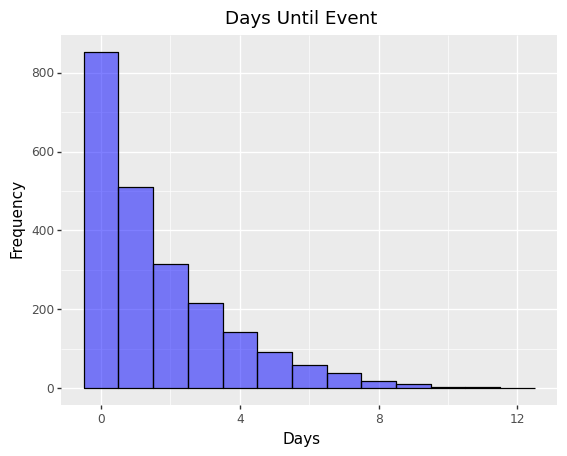

<ggplot: (8789415726608)>

In [50]:
(ggplot() 
 + aes(x=all_data[['Days until Event']])
 + geom_histogram(binwidth=1, color='black', fill='blue', alpha=0.5) 
 + labs(x='Days', y='Frequency', title='Days Until Event')
)

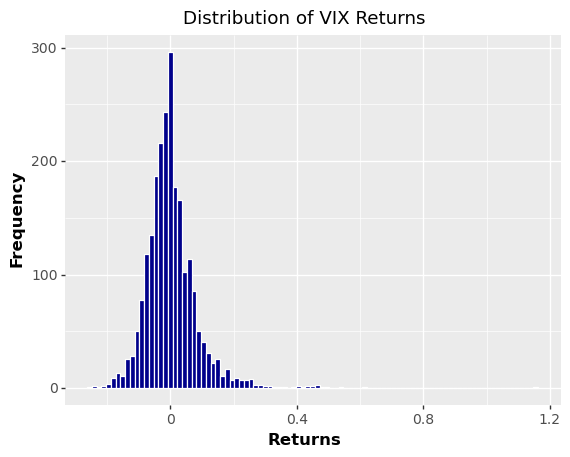

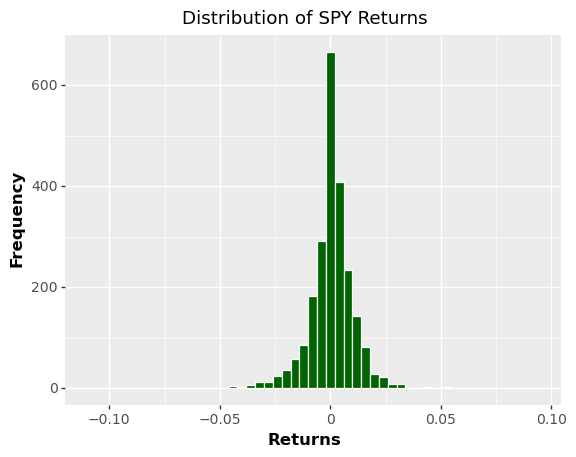

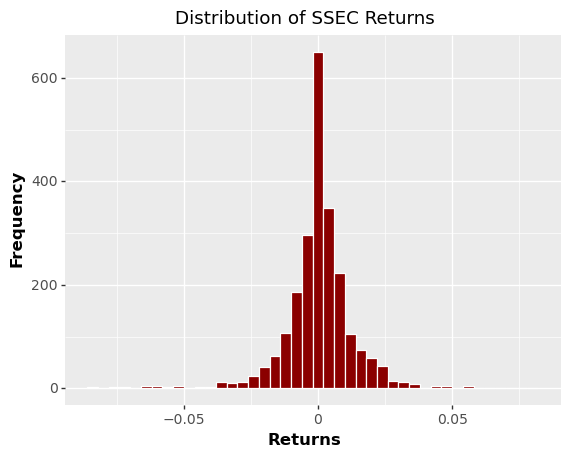

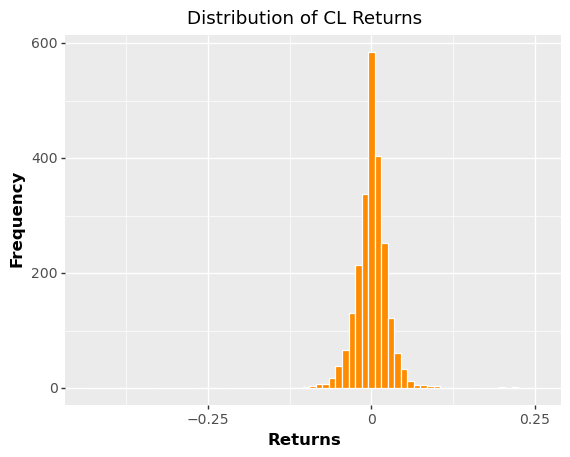

(<ggplot: (8789473405949)>,
 <ggplot: (8789473405937)>,
 <ggplot: (8789520766058)>,
 <ggplot: (8789473405895)>)

In [51]:
hist1 = (ggplot(all_data, aes(x='VIX Returns'))
         + geom_histogram(binwidth=.015, color='white', fill='darkblue')
         + theme(axis_text=element_text(size=10), 
                 axis_title=element_text(size=12, face='bold'))
                + labs(x='Returns', y='Frequency', title='Distribution of VIX Returns')
        )
hist2 = (ggplot(all_data, aes(x='SPY Returns'))
         + geom_histogram(binwidth=.004, color='white', fill='darkgreen')
         + theme(axis_text=element_text(size=10), 
                 axis_title=element_text(size=12, face='bold'))
                + labs(x='Returns', y='Frequency', title='Distribution of SPY Returns')
        )
hist3 = (ggplot(all_data, aes(x='SSEC Returns'))
         + geom_histogram(binwidth=.004, color='white', fill='darkred')
         + theme(axis_text=element_text(size=10), 
                 axis_title=element_text(size=12, face='bold'))
                + labs(x='Returns', y='Frequency', title='Distribution of SSEC Returns')
        )
hist4 = (ggplot(all_data, aes(x='CL Returns'))
                + geom_histogram(binwidth=.01, color='white', fill='darkorange')
                + theme(axis_text=element_text(size=10),
                        axis_title=element_text(size=12, face='bold'))
                + labs(x='Returns', y='Frequency', title='Distribution of CL Returns')
        )
hist1,hist2,hist3,hist4

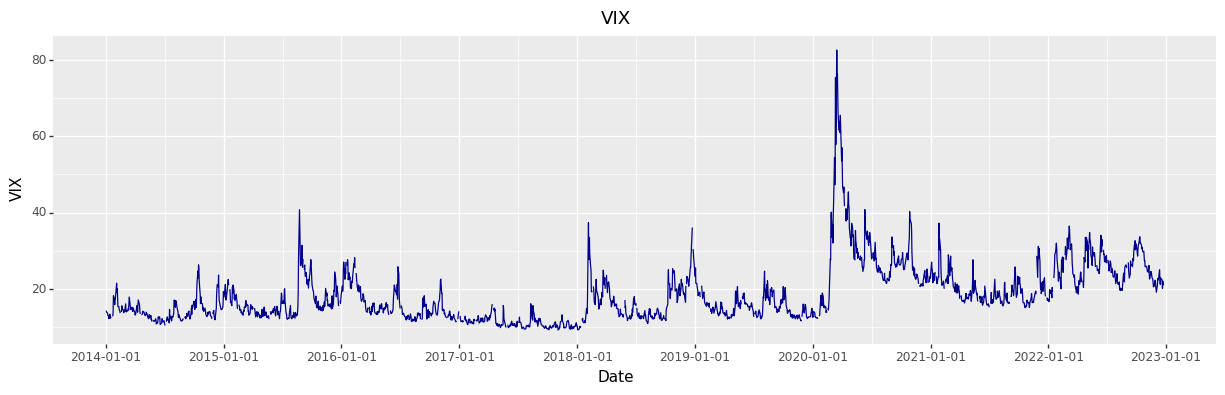

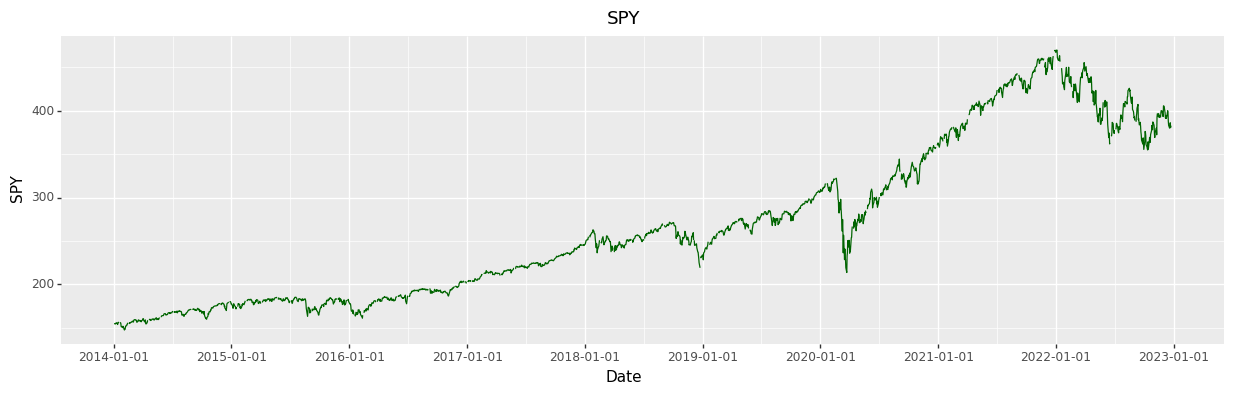

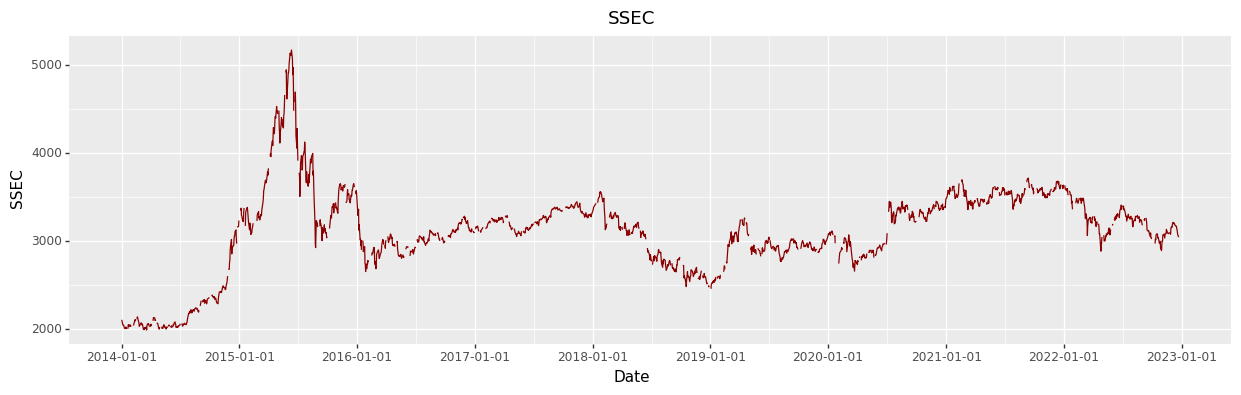

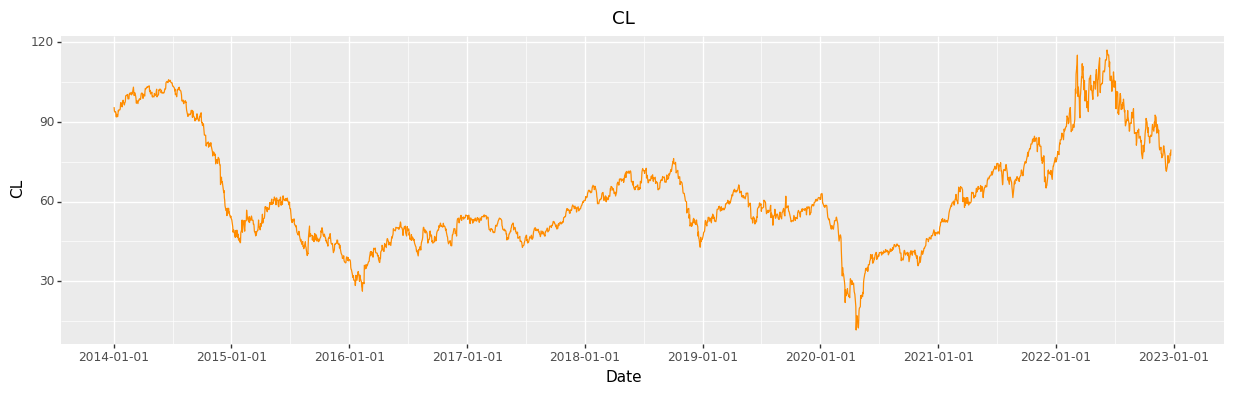

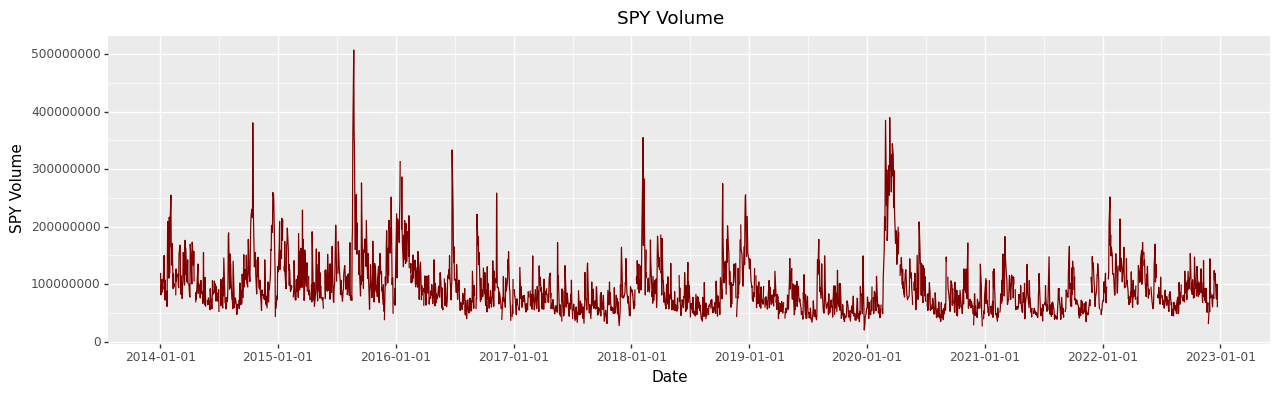

(<ggplot: (8789433091322)>,
 <ggplot: (8789433099021)>,
 <ggplot: (8789433027238)>,
 <ggplot: (8789433091175)>,
 <ggplot: (8789433241531)>)

In [52]:
vix = (ggplot(all_data[['VIX']], aes(x=all_data.index, y='VIX'))
        + geom_line(color='darkblue')
        + theme(figure_size=(15, 4))
        + labs(x='Date', y='VIX', title='VIX')
       )
spy = (ggplot(all_data[['SPY']], aes(x=all_data.index, y='SPY'))
        + geom_line(color='darkgreen')
        + theme(figure_size=(15, 4))
        + labs(x='Date', y='SPY', title='SPY')
        )
ssec = (ggplot(all_data[['SSEC']], aes(x=all_data.index, y='SSEC'))
        + geom_line(color='darkred')
        + theme(figure_size=(15, 4))
        + labs(x='Date', y='SSEC', title='SSEC')
        )
cl = (ggplot(all_data[['CL']], aes(x=all_data.index, y='CL'))
        + geom_line(color='darkorange')
        + theme(figure_size=(15, 4))
        + labs(x='Date', y='CL', title='CL')
        )
spy_volume = (ggplot(all_data[['SPY Volume']], aes(x=all_data.index, y='SPY Volume'))
        + geom_line(color='maroon')
        + theme(figure_size=(15, 4))
        + labs(x='Date', y='SPY Volume', title='SPY Volume')
        )
vix,spy,ssec,cl,spy_volume

In [16]:
predictors['VIX Returns (y)'] = predictors['VIX Returns'].shift(-1)
predictors['SSEC Returns'] = predictors['SSEC Returns'].shift(-1)
predictors = predictors.drop(columns=['VIX Returns'])

predictors = predictors.dropna()

***

# 3 Predicting VIX

In [17]:
START_TRAIN = '2014-01-03'
END_TRAIN = '2014-06-03'

START_TEST = END_TRAIN 
END_TEST = '2020-12-31'

START_VAL = END_TEST 
END_VAL = '2022-12-22'

ROLLING = True

arima_data = predictors.loc[START_TRAIN:END_TEST]

last_train = arima_data.loc[:END_TRAIN].index[-1]
end_train_loc = arima_data.index.get_loc(last_train)

In [18]:
def test_model(p,d,q,thresh_up,thresh_down):
    metrics = pd.DataFrame(index=[str((p,d,q))],columns=['MSE','DA','Up Acc','Down Acc','Tot Significant'])
    predicted_results = pd.DataFrame(index = predictors.loc[START_TEST:END_TEST].index,columns=['predictions'])
    start, end = 0, end_train_loc 
    for i in range(len(arima_data.loc[START_TEST:END_TEST])):
        model = ARIMA(arima_data.iloc[start:end]['VIX Returns (y)'], order=(p,d,q), exog=arima_data.iloc[start:end,:5]).fit()
        forecast = model.forecast(1, exog=arima_data.iloc[end,:5])

        if ROLLING == True:
            start = start + 1 
        end = end + 1 

        predicted_results.iloc[i] = forecast

    predicted_results = predicted_results.dropna()
    predicted_results['actual'] = arima_data.loc[START_TEST:END_TEST,'VIX Returns (y)']

    mse = np.mean((predicted_results['actual'] - predicted_results['predictions']) ** 2)
    da = (np.sign(predicted_results['predictions']) == np.sign(predicted_results['actual'])).sum() / len(predicted_results)

    significant_up = predicted_results[predicted_results['predictions'] > thresh_up]
    acc_up = (np.sign(significant_up['predictions']) == np.sign(significant_up['actual'])).sum() / len(significant_up)
    significant_down = predicted_results[predicted_results['predictions'] < thresh_down]
    acc_down = (np.sign(significant_down['predictions']) == np.sign(significant_down['actual'])).sum() / len(significant_down)
    total_sig = len(significant_up) + len(significant_down)

    metrics.loc[str((p,d,q))] = [mse,da,acc_up,acc_down,total_sig]
    return metrics, predicted_results

In [19]:
param_grid = {
    'p': range(0,5),
    'd': range(0,3),
    'q': range(0,5)
}

param_combinations = list(itertools.product(*(param_grid[param] for param in param_grid)))

def optimize(params):
    p, d, q = params
    metric = test_model(p,d,q,0.07,-0.07)
    return metric 

To optimize our ARIMA parameters, we will use an initial training period of 6m (2014-01 - 2014-06). We will use a rolling window to forecast predictions until the end of 2020. We will then determine our best model based on this period. After selecting the best model, we will use this to test out-of-sample on our validation period.

In [20]:
RUN_OPTIMIZATION = False 

if RUN_OPTIMIZATION:
    optimization_res = pd.DataFrame(columns=['MSE','DA','Up Acc','Down Acc','Tot Significant'])
    for combo in tqdm(param_combinations):
        p, d, q = combo 
        metric = test_model(p,d,q,0.07,-0.07)
        optimization_res.loc[str((p,d,q))] = metric.values[0]
else:
    optimization_res = pd.read_csv('./data/optimization_stats.csv',index_col=0)

In [21]:
optimization_res.sort_values(by='DA',ascending=False).head()

,MSE,DA,Up Acc,Down Acc,Tot Significant
"(0, 0, 1)",0.009271,0.514768,0.500000,0.821429,70
"(4, 1, 4)",0.014459,0.512960,0.448276,0.544118,310
"(3, 2, 4)",0.027534,0.512357,0.448622,0.557841,788
"(0, 1, 0)",0.014551,0.510549,0.448889,0.534483,399
"(1, 0, 0)",0.009306,0.510549,0.512195,0.785714,69


In [22]:
optimization_res.sort_values(by='Up Acc',ascending=False).head()

,MSE,DA,Up Acc,Down Acc,Tot Significant
"(4, 0, 3)",0.010521,0.490054,0.535714,0.625000,112
"(1, 0, 0)",0.009306,0.510549,0.512195,0.785714,69
"(1, 0, 1)",0.009675,0.510549,0.510204,0.766667,79
"(2, 0, 2)",0.010837,0.506329,0.507463,0.693878,116
"(4, 0, 4)",0.011393,0.486438,0.506024,0.688525,144


In [23]:
optimization_res.sort_values(by='Down Acc',ascending=False).head()

,MSE,DA,Up Acc,Down Acc,Tot Significant
"(0, 0, 1)",0.009271,0.514768,0.500000,0.821429,70
"(0, 0, 0)",0.009181,0.504521,0.461538,0.814815,66
"(1, 0, 0)",0.009306,0.510549,0.512195,0.785714,69
"(2, 0, 0)",0.009378,0.499096,0.431818,0.777778,80
"(1, 0, 1)",0.009675,0.510549,0.510204,0.766667,79


Best ones:
- (0,0,1) looks to be most robust one (highest directional accuracy for a simple TS model)

**Testing out of sample**

In [24]:
validation_data = predictors.loc[START_TRAIN:END_VAL]
p, d, q = 1, 1, 1

last_test= validation_data.loc[:END_TRAIN].index[-1]
end_test_loc = validation_data.index.get_loc(last_test)

metrics = pd.DataFrame(columns=['MSE','DA','Up Acc','Down Acc','Tot Significant'])
predicted_results = pd.DataFrame(index = predictors.loc[START_TEST:END_VAL].index,columns=['predictions'])
start, end = 0, end_test_loc 
for i in tqdm(range(len(validation_data.loc[START_TEST:END_VAL]))):
    model = ARIMA(validation_data.iloc[start:end]['VIX Returns (y)'], order=(p,d,q), exog=validation_data.iloc[start:end,:5]).fit()
    forecast = model.forecast(1, exog=validation_data.iloc[end,:5])

    if ROLLING == True:
        start = start + 1 
    end = end + 1 

    predicted_results.iloc[i] = forecast

predicted_results = predicted_results.dropna()
predicted_results['actual'] = validation_data.loc[START_TEST:END_VAL,'VIX Returns (y)']
predicted_results_val = predicted_results.loc[START_VAL:END_VAL]

100%|██████████| 2157/2157 [03:05<00:00, 11.65it/s]


In [25]:
predicted_results_val = predicted_results.loc[START_VAL:END_VAL]

In [26]:
pos_thres = 0.07
neg_thres = -0.07

mse = np.mean((predicted_results_val['actual'] - predicted_results_val['predictions']) ** 2)
da = (np.sign(predicted_results_val['predictions']) == np.sign(predicted_results_val['actual'])).sum() / len(predicted_results_val)

significant_up = predicted_results_val[predicted_results_val['predictions'] > pos_thres]
acc_up = (np.sign(significant_up['predictions']) == np.sign(significant_up['actual'])).sum() / len(significant_up)
significant_down = predicted_results_val[predicted_results_val['predictions'] < neg_thres]
acc_down = (np.sign(significant_down['predictions']) == np.sign(significant_down['actual'])).sum() / len(significant_down)
total_sig = len(significant_up) + len(significant_down)

metrics.loc[str((p,d,q))] = [mse,da,acc_up,acc_down,total_sig]
display(metrics)

,MSE,DA,Up Acc,Down Acc,Tot Significant
"(1, 1, 1)",0.014568,0.48497,0.41791,0.54,117.0


In [47]:
trace1 = go.Scatter(x=predicted_results_val.index, y=predicted_results_val['actual'], mode='lines', name='actual')
trace2 = go.Scatter(x=predicted_results_val.index, y=predicted_results_val['predictions'], mode='lines', name='predicted')
data = [trace1, trace2]
layout = go.Layout(title='Actual vs Predicted', xaxis=dict(title='Date'), yaxis=dict(title='VIX Returns'), legend=dict(x=0, y=1.0, orientation='h'))
fig = go.Figure(data=data, layout=layout)
#pyo.plot(fig, filename='two-lines.html')
fig

## SPY Options

In [27]:
@functools.lru_cache()
def fetch_options_price(option,date):
    data_url = f'https://api.polygon.io/v1/open-close/{option}/{date}?adjusted=true&apiKey=cIrLrp5MiBJNGpjRm4hv7hoSbNVirkxx'
    # data_url = f'https://api.polygon.io/v3/snapshot/options/{ticker}?apiKey=cIrLrp5MiBJNGpjRm4hv7hoSbNVirkxx'
    # data_url = data_url + f'&expiration_data.gte={begin_date}'
    # data_url = data_url + f'&expiration_data.lte={end_date}'
    response = requests.get(data_url)
    if response.status_code == 200:
        return response.json()
    else:
        return response.status_code

In [28]:
def retrieve_options(date):
    dates = spy_data.loc[date:].index[:20]
    atm_put_strike = math.ceil(spy_data.loc[dates[0],'SPY'])
    atm_call_strike = math.floor(spy_data.loc[dates[0],'SPY'])
    
    i = -10 
    call = 404 
    while call == 404:
        last_date = dates[i].strftime('%y%m%d')
        call_code = 'O:SPY' + last_date + 'C' + '00' + str(atm_call_strike) + '000'
        put_code = 'O:SPY' + last_date + 'P' + '00' + str(atm_put_strike) + '000'
        call = fetch_options_price(call_code, date)
        i = i + 1 

    last_date = datetime.datetime.strptime(last_date,'%y%m%d')
    last_date = last_date.strftime('%Y-%m-%d')
    valid_dates = spy_data.loc[dates[0]:last_date].index

    option_prices = pd.DataFrame(index=valid_dates,columns=[call_code,put_code,'SPY'])
    for day in option_prices.index:
        call_res = fetch_options_price(call_code, day.strftime('%Y-%m-%d'))
        put_res = fetch_options_price(put_code, day.strftime('%Y-%m-%d'))

        if not isinstance(call_res, int):
            option_prices.loc[day,call_code] = call_res['close']

        if not isinstance(put_res, int):
            option_prices.loc[day,put_code] = put_res['close']

    option_prices['SPY'] = spy_data.loc[dates[0]:last_date,'SPY']

    return option_prices 

In [29]:
retrieve_options('2022-02-23') # russian invasion 

,O:SPY220309C00415000,O:SPY220309P00416000,SPY
date,,,
2022-02-23,14.88,6.89,415.196034
2022-02-24,16.69,4.32,421.444392
2022-02-25,24.46,2.16,430.743130
2022-02-28,23.81,3.2,429.641057
2022-03-01,18.49,3.71,423.097501
2022-03-02,21.12,1.49,430.880889
2022-03-03,24.41,1.45,428.735783
2022-03-04,17.5,1.37,425.252447
2022-03-07,7.04,3.67,412.716370
